In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from math import log, sqrt
import scipy.stats

# Cogsci 131 - Assignment 9

Selena Zhang

## Question 1


We expect the probabilities to be particularly small, so taking the log of the probabilities will help better scale them to be easier for the program to compute with more accuracy.

## Question 2

The acceptance ratio prevents us from doing an integral because it allows us to cancel out the summations in the denominator and calculate it easier. 
Starting off with a derivation of Bayes's rule:
$$P(W|D) = \frac{P(D|W)*P(W)}{\sum_i P(D|W_i)*P(W_i)}$$
Similarly, we know that 
$$P(W'|D) = \frac{P(D|W')*P(W')}{\sum_i P(D|W_i)*P(W_i)}$$
That means that 
$$\frac{P(W'|D)}{P(W|D)} = \frac{P(D|W')*P(W')}{P(D|W)*P(W)}$$
which shows that the integral/summation has disappeared.

## Question 3

In [5]:
df = pd.read_csv('Assignment9-data.csv')
n1 = df['n1'].values
n2 = df['n2'].values
a = df['correct'].values
W = np.random.uniform(0, 1, 1)

def log_likelihood(n1, n2, a, W):
    # this function takes a numpy array for n1, n2, and the accuracy (0/1), whether they answerd correctly
    # as well as W (the hypothesis)
    # and returns the *log* likelihood of the responses, log P(accuracy | n1, n2, W)
    
    assert(len(n1) == len(n2) == len(a))

    p = 1.0-scipy.stats.norm.cdf(0, loc=np.abs(n1-n2), scale=W*np.sqrt(n1**2 + n2**2)) # the probability of answering correctly
    return np.sum(np.where(a, np.log(p), np.log(1.0-p)))
    
##
## Your code goes here ###
##

def log_prior(W):
    if W < 0:
        return 0
    #all other cases
    else:
        return log(np.exp(-W))

def log_posterior(W):
    loglike = log_likelihood(n1, n2, a, W)
    return log_prior(W) + loglike
#test
log_posterior(W)

-1812.5966739837525

## Question 4

In [6]:
def metropolis_algorithm(W, iterations):
    #returns a list of w_values and posterior_score
    #set up
    w_values = []
    post_score = []
    w_values.append(W)
    u = np.random.uniform(0, 1)
    for i in range(iterations):
        w_recent = w_values[-1]
        w_prime = w_recent + np.random.normal(0, 0.1)
        log_post_prime = log_posterior(w_prime)
        log_post_recent = log_posterior(w_recent)
        acceptance_ratio = log_post_prime-log_post_recent
        if acceptance_ratio > 1:
            #accept W'
            w_values.append(w_prime)
            post_score.append(log_post_prime)
        else:
            u = np.log(np.random.uniform(0, 1))
            if acceptance_ratio >= u:
                #accept W'
                w_values.append(w_prime)
                post_score.append(log_post_prime)
            else:
                #keep original
                w_values.append(w_recent)
                post_score.append(log_post_recent)
    return [w_values, post_score]

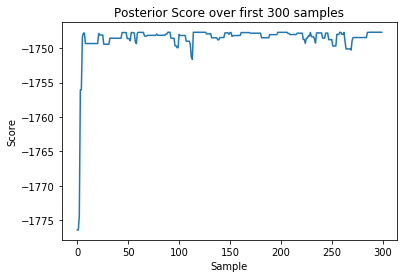

In [196]:
#plot posterior
W = np.random.random()
metro = metropolis_algorithm(W, 11000)
plt.plot(range(300), metro[1][:300])
plt.title("Posterior Score over first 300 samples")
plt.xlabel("Sample")
plt.ylabel("Score")
plt.show()

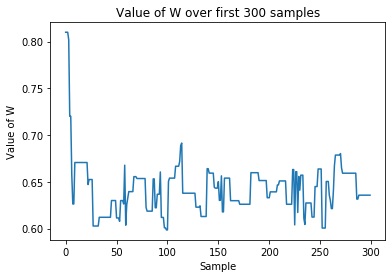

In [197]:
#plot samples
plt.plot(range(300), metro[0][:300])
plt.title("Value of W over first 300 samples")
plt.xlabel("Sample")
plt.ylabel("Value of W")
plt.show()

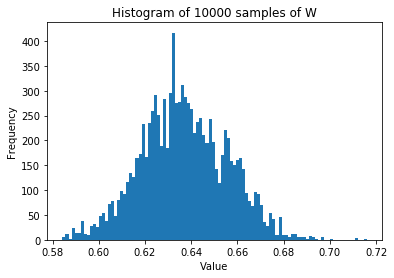

In [198]:
#plot histogram
plt.hist(metro[0][1000:], bins = 100)
plt.title("Histogram of 10000 samples of W")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

## Question 5

In [199]:
counter = 0
for i in metro[0][1000:]:
    if (i >= 0.60 and i <= 0.65):
        counter += 1
result = counter/10000
result

0.7349

The probability that W is in the interval $[0.60, 0.65]$ is 73.49%

## Question 6

In [3]:
def metropolis_prior(W, iterations):
    #returns a list of w_values and score, but this uses the prior instead of the posterior.
    #set up
    w_values = []
    score = []
    w_values.append(W)
    u = np.random.uniform(0, 1)
    for i in range(iterations):
        w_recent = w_values[-1]
        w_prime = w_recent + np.random.normal(0, 0.1)
        log_prior_prime = log_prior(w_prime)
        log_prior_recent = log_prior(w_recent)
        acceptance_ratio = log_prior_prime - log_prior_recent
        if acceptance_ratio > 1:
            #accept W', append prior
            w_values.append(w_prime)
            score.append(log_prior_prime)
        else:
            u = np.log(np.random.uniform(0, 1))
            if acceptance_ratio >= u:
                #accept W', append prior
                w_values.append(w_prime)
                score.append(log_prior_prime)
            else:
                #keep W.
                w_values.append(w_recent)
                score.append(log_prior_recent)
    return [w_values, score]

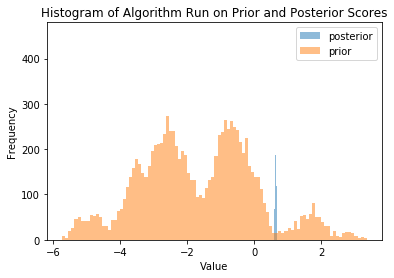

In [11]:
#plotting
W = np.random.random()
prior = metropolis_prior(W, 11000)
post = metropolis_algorithm(W, 11000)
plt.hist(post[0][1000:], bins = 100, alpha = 0.5, label = 'posterior')
plt.hist(prior[0][1000:], bins = 100, alpha =0.5, label = 'prior')
plt.title("Histogram of Algorithm Run on Prior and Posterior Scores")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()

The prior samples on a much wider range of values than the posterior. We saw in quesion 4 that the bulk of posterior samples tended to be in the 0.6-0.7 range, but here, they have a relatively small range compared to the prior. We know that the posterior probability is proportional to the likelihood times the prior, which means that if the prior is large, then the likelihood is much smaller in order to make the equation hold. That means that the posterior is much more accurate than the prior.

## Question 7

I would use the average of the list as the "true" value, and then define a function that compiles the sum of squared errors of each value with respect to the mean. I would then run each of these functions 100 times to get closer to the true values: 

In [216]:
def goodness(sample_list):
    avg = np.mean(sample_list)
    count = 0
    for i in sample_list:
        if (i-avg)**2 <= 0.1:
            count += 1
    return count

In [217]:
W = np.random.random()
score_once = []
score_ten = []
for i in range(100):
    metropolis_once = 0
    metropolis_once = metropolis_algorithm(W, 1000)
    score_once.append(goodness(metropolis_once[0]))
for i in range(100):
    for i in range(10):
        metropolis_ten = 0
        metropolis_ten = metropolis_algorithm(W, 100)
        score_ten.append(goodness(metropolis_ten[0]))      

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
